<a href="https://colab.research.google.com/github/HST0077/HYOTC/blob/main/StepDown_2stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2 Stock Step Down 상품 평가하기

In [2]:
# 주말 제외한 6개월마다의 날짜 생성
import pandas as pd

D0=pd.date_range('2026-01-02',periods=6,freq=pd.DateOffset(months=6))
D0

DatetimeIndex(['2026-01-02', '2026-07-02', '2027-01-02', '2027-07-02',
               '2028-01-02', '2028-07-02'],
              dtype='datetime64[ns]', freq='<DateOffset: months=6>')

In [3]:
# 대한민국의 달력기준으로 데이터 만들기
import holidays # 별도로 설치하여야 함

# 주말을 제외한 대한민국의 휴일 정보를 가져온다.
kor_holidays=list(holidays.KOR(years=range(2025,2029)).keys()) #list()데이터로 변환
kor_holidays=pd.to_datetime(kor_holidays) # 데이터프레임 날짜로 변환

# Business days로 6개의 날짜 생성
D_samples=pd.date_range('2026-01-02',periods=6,freq=pd.DateOffset(months=6))

# 생성된 날짜에서 대한민국 휴일 제외
# 아래에서 사용된 isin()은 존재하는지를 확인하는 내장함수
D0=D_samples[~D_samples.isin(kor_holidays)] # 휴일정보에 포함되지 않는 날짜만 추출
D0

DatetimeIndex(['2026-01-02', '2026-07-02', '2027-01-02', '2027-07-02',
               '2028-01-02', '2028-07-02'],
              dtype='datetime64[ns]', freq='<DateOffset: months=6>')

In [4]:
import pandas as pd
import holidays
from datetime import datetime

# 대한민국 공휴일 불러오기
kor_holidays = list(holidays.KOR(years=range(2026, 2031)).keys())
kor_holidays = pd.to_datetime(kor_holidays)

# 오늘 날짜
today = pd.to_datetime(datetime.today().date())
six_months_later = today + pd.DateOffset(months=6)

# 6개월마다의 기준일 생성
month_starts = pd.date_range(start=six_months_later, periods=6, freq=pd.DateOffset(months=6))

# 각 기준일에서 해당 월의 첫 번째 영업일(공휴일 제외) 추출
business_days = []
for dt in month_starts:
    # 시작 날짜부터 한 달간의 영업일 추출
    month_range = pd.date_range(start=dt, end=dt + pd.offsets.MonthEnd(0), freq='B')
    # 영업일이 대한민국의 휴일이 아닌 것을 다시 추출출
    valid_days = [d for d in month_range if d not in kor_holidays]
    if valid_days: # 자료가 있다면
        business_days.append(valid_days[0])

# 결과 출력
print(business_days)


[Timestamp('2026-07-06 00:00:00'), Timestamp('2027-01-04 00:00:00'), Timestamp('2027-07-05 00:00:00'), Timestamp('2028-01-04 00:00:00'), Timestamp('2028-07-04 00:00:00'), Timestamp('2029-01-04 00:00:00')]


In [5]:
from datetime import datetime

# 날짜 차이 계산 (단위: 일수)
days_diff = [(d - today).days for d in business_days]

# DataFrame 생성
df = pd.DataFrame({
    '영업일': [d.strftime('%Y-%m-%d') for d in business_days],
    '오늘까지 남은 일수': days_diff})
df

,영업일,오늘까지 남은 일수
0,2026-07-06,183
1,2027-01-04,365
2,2027-07-05,547
3,2028-01-04,730
4,2028-07-04,912
5,2029-01-04,1096


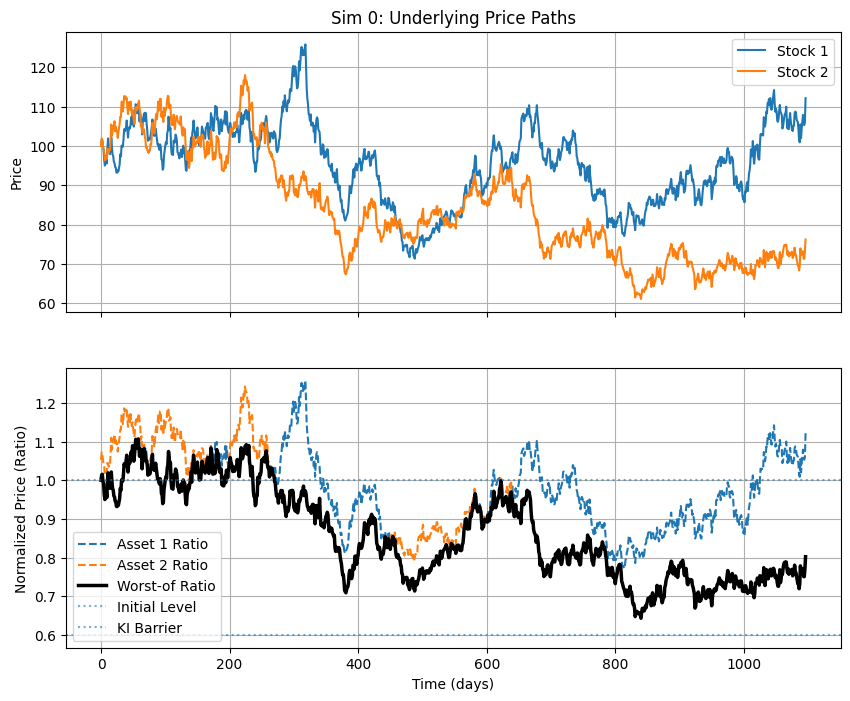

In [6]:
# 시뮬레이션 횟수 만큼 주가 2개 생성하기
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 주가 경로 생성
N=df['오늘까지 남은 일수'].iloc[-1] # 만기까지의 날짜수
sim=1000 # 시뮬레이션 회수
r = 0.05
sigma1, sigma2 = 0.30, 0.30
rho = 0.6 # 상관계수
dt = 1 / 365

np.random.seed(111)

# 기초자산 초기 가격 세팅
S0_1, S0_2 = 100.0, 100.0
kijun_price_1,kijun_price_2  = 100.0, 95.0

# ======================================================
# 1) 상관 표준정규 난수 생성
# ======================================================
cov = np.array([[1.0, rho],
                [rho, 1.0]])

W = multivariate_normal.rvs(
    mean=[0.0, 0.0],
    cov=cov,
    size=(N, sim)
)

W1 = W[:, :, 0]
W2 = W[:, :, 1]

# ======================================================
# 2) GBM log-price increments
# ======================================================
drift1 = (r - 0.5 * sigma1**2) * dt
drift2 = (r - 0.5 * sigma2**2) * dt

vol1 = sigma1 * np.sqrt(dt)
vol2 = sigma2 * np.sqrt(dt)

lnS1 = drift1 + vol1 * W1
lnS2 = drift2 + vol2 * W2

# t=0 포함
lnS1 = np.insert(lnS1, 0, np.log(S0_1), axis=0)
lnS2 = np.insert(lnS2, 0, np.log(S0_2), axis=0)

S1 = np.exp(np.cumsum(lnS1, axis=0))  # (N+1, sim)
S2 = np.exp(np.cumsum(lnS2, axis=0))  # (N+1, sim)

# ======================================================
# 3) 기준가격으로 정규화 → worst-of
# ======================================================
ratio1 = S1 / kijun_price_1
ratio2 = S2 / kijun_price_2

# ⭐ worst-of (비율 기준)
worst_of = np.minimum(ratio1, ratio2)   # (N+1, sim)

# ======================================================
# 4) 첫번째 sim의 path 보기
# ======================================================
# 첫 번째 시뮬레이션 인덱스
i = 0

S1_path = S1[:, i]
S2_path = S2[:, i]
ratio1_path = ratio1[:, i]
ratio2_path = ratio2[:, i]
worst_path = worst_of[:, i]

time = np.arange(len(S1_path))  # 0 ~ N

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 가격 경로
axes[0].plot(time, S1_path, label='Stock 1')
axes[0].plot(time, S2_path, label='Stock 2')
axes[0].set_ylabel('Price')
axes[0].set_title('Sim 0: Underlying Price Paths')
axes[0].legend()
axes[0].grid(True)

# worst-of
# ===== worst-of subplot =====
axes[1].plot(
    time, ratio1_path,
    linestyle='--', linewidth=1.5,
    label='Asset 1 Ratio'
)

axes[1].plot(
    time, ratio2_path,
    linestyle='--', linewidth=1.5,
    label='Asset 2 Ratio'
)

axes[1].plot(
    time, worst_path,
    color='black', linewidth=2.5,
    label='Worst-of Ratio'
)

# 기준선
axes[1].axhline(1.0, linestyle=':', alpha=0.6, label='Initial Level')
axes[1].axhline(0.6, linestyle=':', alpha=0.6, label='KI Barrier')

axes[1].set_ylabel('Normalized Price (Ratio)')
axes[1].set_xlabel('Time (days)')
axes[1].legend()
axes[1].grid(True)

plt.show()


In [7]:
def SD_2star_CPU(S, kijun, K, T, c, r, q, sigma, rho, barrier, dummy, sim, seed=111):
    """
    2-star ELS Monte Carlo (worst-of, early redemption, KI barrier)

    Parameters
    - S      : (2,) 초기 주가 [S0_1, S0_2]
    - kijun  : (2,) 기준가격 [kijun_1, kijun_2]
    - K      : (EN,) 조기상환/만기 평가 기준 (ratio 기준) 예: [0.95, 0.90, ...]
    - T      : (EN,) 관측일(일 단위, 정수). 마지막 원소가 만기일.
    - c      : (EN,) 해당 회차 상환 쿠폰(예: 0.02면 2%)
    - r      : 무위험이자율(연)
    - q      : (2,) 배당률(연) [q1, q2]
    - sigma  : (2,) 변동성(연) [sig1, sig2]
    - rho    : 상관계수
    - barrier: KI 배리어 (ratio 기준) 예: 0.65
    - dummy  : KI 미발생 시 만기 쿠폰(예: 0.10) 또는 지급률(상품 정의에 맞게)
    - sim    : 시뮬레이션 개수
    - seed   : 난수 seed

    Returns
    - mu, s  : Price의 정규 적합 (평균, 표준편차)
    - Price  : (sim,) 시뮬레이션별 현재가치(PV)
    """

    import numpy as np
    from scipy.stats import norm, multivariate_normal

    # ---- 입력 정리 ----
    S = np.asarray(S, dtype=float).reshape(2,)
    kijun = np.asarray(kijun, dtype=float).reshape(2,)
    sigma = np.asarray(sigma, dtype=float).reshape(2,)
    q = np.asarray(q, dtype=float).reshape(2,)

    K = np.asarray(K, dtype=float)
    T = np.asarray(T, dtype=int)
    c = np.asarray(c, dtype=float)

    EN = len(T)
    if not (len(K) == EN and len(c) == EN):
        raise ValueError("K, T, c의 길이는 같아야 합니다. (EN회차)")

    # 만기까지 일수 (시뮬 경로 길이)
    N = int(T[-1])
    if N <= 0:
        raise ValueError("T[-1] (만기일)은 양의 정수(일)여야 합니다.")

    dt = 1.0 / 365.0

    np.random.seed(seed)

    # ======================================================
    # 1) 상관 표준정규 난수 생성: W shape = (N, sim, 2)
    # ======================================================
    cov = np.array([[1.0, rho],
                    [rho, 1.0]], dtype=float)

    W = multivariate_normal.rvs(mean=[0.0, 0.0], cov=cov, size=(N, sim))
    # W: (N, sim, 2)
    W1 = W[:, :, 0]
    W2 = W[:, :, 1]

    # ======================================================
    # 2) GBM 경로 (q 반영): d ln S = (r - q - 0.5σ^2)dt + σ sqrt(dt) dW
    # ======================================================
    drift1 = (r - q[0] - 0.5 * sigma[0]**2) * dt
    drift2 = (r - q[1] - 0.5 * sigma[1]**2) * dt

    vol1 = sigma[0] * np.sqrt(dt)
    vol2 = sigma[1] * np.sqrt(dt)

    lnS1 = drift1 + vol1 * W1  # (N, sim)
    lnS2 = drift2 + vol2 * W2  # (N, sim)

    # t=0 포함 -> (N+1, sim)
    lnS1 = np.insert(lnS1, 0, np.log(S[0]), axis=0)
    lnS2 = np.insert(lnS2, 0, np.log(S[1]), axis=0)

    S1 = np.exp(np.cumsum(lnS1, axis=0))
    S2 = np.exp(np.cumsum(lnS2, axis=0))

    # ======================================================
    # 3) 기준가격으로 정규화 & worst-of (ratio)
    # ======================================================
    ratio1 = S1 / kijun[0]
    ratio2 = S2 / kijun[1]
    R = np.minimum(ratio1, ratio2)  # (N+1, sim)

    # ======================================================
    # 4) 조기상환 (아직 상환 안 된 것만)
    # ======================================================
    Price = np.zeros(sim, dtype=float)

    for i in range(EN - 1):  # 마지막은 만기, 조기상환 관측은 통상 만기 전까지라 가정
        t = int(T[i])
        alive = (Price == 0.0)
        hit = alive & (R[t, :] >= K[i])
        Price[hit] = 10000.0 * (1.0 + c[i]) * np.exp(-r * t / 365.0)

    # ======================================================
    # 5) 만기상환 (남은 것만)
    #    KI 발생: 경로 전체에서 min(R) < barrier
    # ======================================================
    alive = (Price == 0.0)
    if np.any(alive):
        R_alive = R[:, alive]                   # (N+1, n_alive)
        ki_hit = (R_alive.min(axis=0) < barrier)

        t_mat = int(T[-1])

        # KI 발생 -> 원금*만기 worst-of 비율로 상환(상품 정의에 맞춘 형태)
        Price_alive = np.empty(R_alive.shape[1], dtype=float)
        Price_alive[ki_hit] = 10000.0 * R_alive[-1, ki_hit] * np.exp(-r * t_mat / 365.0)

        # KI 미발생 -> 더미(만기 쿠폰 등) 지급
        Price_alive[~ki_hit] = 10000.0 * (1.0 + dummy) * np.exp(-r * t_mat / 365.0)

        Price[alive] = Price_alive

    # 정규분포 적합
    mu, s = norm.fit(Price)

    return mu


In [8]:
# 스텝다운 상품 평가 정보 (2-stock 예시)
S0 = [100, 100]
kijun = [100, 95]          # 예시로 2번째만 95로 둠
r = 0.035
q = [0,0]
sigma = [0.3, 0.5]
rho = 0.6

barrier = 0.65
dummy = 0.132
sim = 10000

K = [0.95, 0.95, 0.95, 0.90, 0.90, 0.85]

# ✅ 관측일은 K 길이(=6)와 같아야 함: 예시로 df에서 6개 뽑는 형태
# (실제론 상품 관측일에 맞춰 넣어야 함)
T = np.array(df['오늘까지 남은 일수'].iloc[:6], dtype=int)

c = np.array([1, 2, 3, 4, 5, 6]) * 0.022

SD_2star_CPU(S0, kijun, K, T, c, r, q, sigma, rho, barrier, dummy, sim)


np.float64(8059.864321312193)

In [9]:
def SD_2star_GPU(S, kijun, K, T, c, r, q, sigma, rho, barrier, dummy, sim, seed=111):
    """
    2-star ELS Monte Carlo (worst-of, early redemption, KI barrier)

    Parameters
    - S      : (2,) 초기 주가 [S0_1, S0_2]
    - kijun  : (2,) 기준가격 [kijun_1, kijun_2]
    - K      : (EN,) 조기상환/만기 평가 기준 (ratio 기준) 예: [0.95, 0.90, ...]
    - T      : (EN,) 관측일(일 단위, 정수). 마지막 원소가 만기일.
    - c      : (EN,) 해당 회차 상환 쿠폰(예: 0.02면 2%)
    - r      : 무위험이자율(연)
    - q      : (2,) 배당률(연) [q1, q2]
    - sigma  : (2,) 변동성(연) [sig1, sig2]
    - rho    : 상관계수
    - barrier: KI 배리어 (ratio 기준) 예: 0.65
    - dummy  : KI 미발생 시 만기 쿠폰(예: 0.10) 또는 지급률(상품 정의에 맞게)
    - sim    : 시뮬레이션 개수
    - seed   : 난수 seed

    Returns
    - mu, s  : Price의 정규 적합 (평균, 표준편차)
    - Price  : (sim,) 시뮬레이션별 현재가치(PV)
    """

    import cupy as cp
    import numpy as np
    from scipy.stats import norm, multivariate_normal

    # ---- 입력 정리 ----
    S = np.asarray(S, dtype=float).reshape(2,)
    kijun = np.asarray(kijun, dtype=float).reshape(2,)
    sigma = np.asarray(sigma, dtype=float).reshape(2,)
    q = np.asarray(q, dtype=float).reshape(2,)

    K = np.asarray(K, dtype=float)
    T = np.asarray(T, dtype=int)
    c = np.asarray(c, dtype=float)

    EN = len(T)
    if not (len(K) == EN and len(c) == EN):
        raise ValueError("K, T, c의 길이는 같아야 합니다. (EN회차)")

    # 만기까지 일수 (시뮬 경로 길이)
    N = int(T[-1])
    if N <= 0:
        raise ValueError("T[-1] (만기일)은 양의 정수(일)여야 합니다.")

    dt = 1.0 / 365.0

    # ---- GPU로 올리기 ----
    S_cp = cp.asarray(S)
    kijun_cp = cp.asarray(kijun)
    sigma_cp = cp.asarray(sigma)
    q_cp = cp.asarray(q)

    K_cp = cp.asarray(K)
    T_cp = cp.asarray(T)
    c_cp = cp.asarray(c)

    cp.random.seed(seed)

    # ======================================================
    # 1) 상관 표준정규 난수 생성 (GPU)
    #    Z ~ N(0, I), W = Z @ L^T, Corr = [[1,rho],[rho,1]]
    # ======================================================
    Z = cp.random.standard_normal((N, sim, 2), dtype=cp.float64)

    # 2x2 촐레스키는 직접 닫힌형으로 만들어도 되지만, 일반적으로 cholesky 사용
    Corr = cp.array([[1.0, rho],
                     [rho, 1.0]], dtype=cp.float64)
    L = cp.linalg.cholesky(Corr)

    W = Z @ L.T
    W1 = W[:, :, 0]
    W2 = W[:, :, 1]

    # ======================================================
    # 2) GBM 경로 (q 반영)
    # ======================================================
    drift1 = (r - q_cp[0] - 0.5 * sigma_cp[0]**2) * dt
    drift2 = (r - q_cp[1] - 0.5 * sigma_cp[1]**2) * dt

    vol1 = sigma_cp[0] * cp.sqrt(dt)
    vol2 = sigma_cp[1] * cp.sqrt(dt)

    lnS1 = drift1 + vol1 * W1   # (N, sim)
    lnS2 = drift2 + vol2 * W2   # (N, sim)

    # t=0 포함
    lnS1 = cp.concatenate([cp.full((1, sim), cp.log(S_cp[0]), dtype=cp.float64), lnS1], axis=0)  # (N+1, sim)
    lnS2 = cp.concatenate([cp.full((1, sim), cp.log(S_cp[1]), dtype=cp.float64), lnS2], axis=0)

    S1 = cp.exp(cp.cumsum(lnS1, axis=0))
    S2 = cp.exp(cp.cumsum(lnS2, axis=0))

    # ======================================================
    # 3) 기준가격 정규화 & worst-of ratio
    # ======================================================
    ratio1 = S1 / kijun_cp[0]
    ratio2 = S2 / kijun_cp[1]
    R = cp.minimum(ratio1, ratio2)  # (N+1, sim)

     # ======================================================
    # 4) 조기상환 (벡터 마스킹, GPU)
    # ======================================================
    Price = cp.zeros(sim, dtype=cp.float64)

    for i in range(EN - 1):
        t = int(T[i])  # Python int로 인덱싱
        alive = (Price == 0.0)
        hit = alive & (R[t, :] >= K_cp[i])
        Price = cp.where(
            hit,
            10000.0 * (1.0 + c_cp[i]) * cp.exp(-r * t / 365.0),
            Price
        )

    # ======================================================
    # 5) 만기상환 (남은 것만)
    # ======================================================
    alive = (Price == 0.0)
    if cp.any(alive):
        R_alive = R[:, alive]  # (N+1, n_alive)
        ki_hit = (cp.min(R_alive, axis=0) < barrier)

        t_mat = int(T[-1])

        payoff_ki = 10000.0 * R_alive[-1, :] * cp.exp(-r * t_mat / 365.0)
        payoff_no_ki = 10000.0 * (1.0 + dummy) * cp.exp(-r * t_mat / 365.0)

        Price_alive = cp.where(ki_hit, payoff_ki, payoff_no_ki)
        Price[alive] = Price_alive

    # ======================================================
    # 6) mu만 반환 (GPU에서 평균 계산 후 CPU 스칼라로)
    # ======================================================
    mu = float(cp.mean(Price).get())
    return mu


In [10]:
# 스텝다운 상품 평가 정보 (2-stock 예시)
S0 = [100, 100]
kijun = [100, 95]          # 예시로 2번째만 95로 둠
r = 0.035
q = [0,0]
sigma = [0.3, 0.5]
rho = 0.6

barrier = 0.65
dummy = 0.132
sim = 10000

K = [0.95, 0.95, 0.95, 0.90, 0.90, 0.85]

# ✅ 관측일은 K 길이(=6)와 같아야 함: 예시로 df에서 6개 뽑는 형태
# (실제론 상품 관측일에 맞춰 넣어야 함)
T = np.array(df['오늘까지 남은 일수'].iloc[:6], dtype=int)

c = np.array([1, 2, 3, 4, 5, 6]) * 0.022

SD_2star_GPU(S0, kijun, K, T, c, r, q, sigma, rho, barrier, dummy, sim)

8110.177510446253

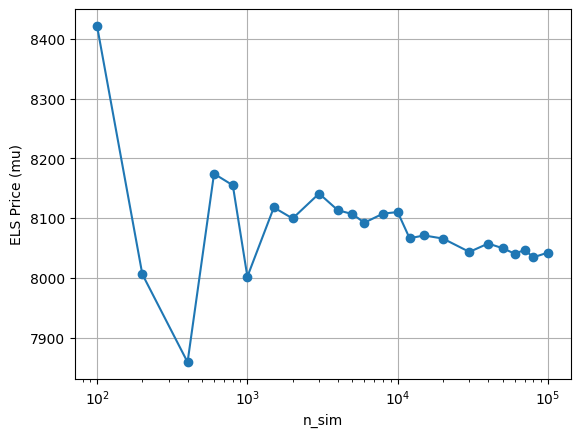

In [11]:
Sims=[100,200,400,600,800,1000,1500,2000,3000,4000,
      5000,6000,8000,10000,12000,15000,20000,30000,
      40000,50000,60000,70000,80000,100000]

Price_Sims=[]
for sim in Sims:
    res=SD_2star_GPU(S0, kijun, K, T, c, r, q, sigma, rho, barrier, dummy, sim)
    Price_Sims.append(res)

plt.figure()
plt.plot(Sims, Price_Sims, marker='o')
plt.xscale('log')  # 로그스케일로 보면 수렴이 잘 보임
plt.xlabel("n_sim")
plt.ylabel("ELS Price (mu)")
plt.grid(True)
plt.show()

In [12]:
def SD_2star_GPU_CRN(
    S, kijun, K, T, c, r, q, sigma, rho, barrier, dummy,
    sim, seed=111, antithetic=True,
    Z=None, return_Z=False,
    notional=10000.0, dtype="float64"
):
    """
    2자산(worst-of) StepDown ELS GPU pricer with CRN support

    - Z=None이면 내부에서 표준정규 Z를 생성 (seed/antithetic 적용)
      * Z shape: (N, sim, 2)  where N = T[-1]
    - Z를 넘기면 해당 Z를 그대로 사용 (완전 CRN)
      * 이 경우 N은 Z.shape[0]로 고정되고, T[-1] <= N 이어야 함
    - return_Z=True이면 (mu, Z) 반환

    Returns
    - mu 또는 (mu, Z)
    """

    import cupy as cp
    import numpy as np

    # ---------- 입력 정리 ----------
    S_np = np.asarray(S, dtype=float).reshape(2,)
    kijun_np = np.asarray(kijun, dtype=float).reshape(2,)
    sigma_np = np.asarray(sigma, dtype=float).reshape(2,)
    q_np = np.asarray(q, dtype=float).reshape(2,)

    T_np = np.atleast_1d(np.asarray(T, dtype=int))
    K_np = np.atleast_1d(np.asarray(K, dtype=float))
    c_np = np.atleast_1d(np.asarray(c, dtype=float))

    EN = len(T_np)
    if not (len(K_np) == EN and len(c_np) == EN):
        raise ValueError("K, T, c의 길이는 같아야 합니다. (EN회차)")

    # dtype
    dtype_cp = cp.float64 if dtype == "float64" else cp.float32

    # ---------- GPU로 올리기 ----------
    S_cp = cp.asarray(S_np, dtype=dtype_cp)
    kijun_cp = cp.asarray(kijun_np, dtype=dtype_cp)
    sigma_cp = cp.asarray(sigma_np, dtype=dtype_cp)
    q_cp = cp.asarray(q_np, dtype=dtype_cp)

    K_cp = cp.asarray(K_np, dtype=dtype_cp)
    c_cp = cp.asarray(c_np, dtype=dtype_cp)

    dt = dtype_cp(1.0 / 365.0)

    # ---------- Z 준비 (CRN) ----------
    if Z is None:
        N = int(T_np[-1])
        if N <= 0:
            raise ValueError("T[-1] (만기일)은 양의 정수(일)여야 합니다.")

        cp.random.seed(seed)

        if antithetic:
            # (N, half, 2) 만든 후 (Z, -Z) 붙여 sim 맞추기
            half = (sim + 1) // 2
            Z_half = cp.random.standard_normal((N, half, 2), dtype=dtype_cp)
            Z = cp.concatenate([Z_half, -Z_half], axis=1)[:, :sim, :]
        else:
            Z = cp.random.standard_normal((N, sim, 2), dtype=dtype_cp)
    else:
        # 외부 Z를 쓰면 호라이즌은 Z가 결정
        if not hasattr(Z, "shape") or len(Z.shape) != 3 or Z.shape[2] != 2:
            raise ValueError("Z는 (N, sim, 2) 형태여야 합니다.")
        N, sim_Z, _ = Z.shape
        sim = int(sim_Z)

        if int(T_np[-1]) > N:
            raise ValueError(f"T[-1]={int(T_np[-1])}가 Z의 N={N}보다 큽니다. Z를 더 길게 생성하세요.")

        # dtype 맞추기(필요시)
        Z = Z.astype(dtype_cp, copy=False)

    # ---------- 상관 부여: W = Z @ L.T ----------
    Corr = cp.array([[1.0, rho], [rho, 1.0]], dtype=dtype_cp)
    L = cp.linalg.cholesky(Corr)
    W = Z @ L.T
    W1 = W[:, :, 0]  # (N, sim)
    W2 = W[:, :, 1]  # (N, sim)

    # ---------- GBM 경로 ----------
    drift1 = (r - q_cp[0] - 0.5 * sigma_cp[0] ** 2) * dt
    drift2 = (r - q_cp[1] - 0.5 * sigma_cp[1] ** 2) * dt
    vol1 = sigma_cp[0] * cp.sqrt(dt)
    vol2 = sigma_cp[1] * cp.sqrt(dt)

    lnS1 = drift1 + vol1 * W1
    lnS2 = drift2 + vol2 * W2

    lnS1 = cp.concatenate([cp.full((1, sim), cp.log(S_cp[0]), dtype=dtype_cp), lnS1], axis=0)  # (N+1, sim)
    lnS2 = cp.concatenate([cp.full((1, sim), cp.log(S_cp[1]), dtype=dtype_cp), lnS2], axis=0)

    S1 = cp.exp(cp.cumsum(lnS1, axis=0))
    S2 = cp.exp(cp.cumsum(lnS2, axis=0))

    # ---------- worst-of ratio ----------
    ratio1 = S1 / kijun_cp[0]
    ratio2 = S2 / kijun_cp[1]
    R = cp.minimum(ratio1, ratio2)  # (N+1, sim)

    # ---------- 조기상환 ----------
    Price = cp.zeros(sim, dtype=dtype_cp)

    for i in range(EN - 1):
        t = int(T_np[i])
        alive = (Price == 0.0)
        hit = alive & (R[t, :] >= K_cp[i])
        Price = cp.where(
            hit,
            dtype_cp(notional) * (dtype_cp(1.0) + c_cp[i]) * cp.exp(-r * t / 365.0),
            Price
        )

    # ---------- 만기상환 ----------
    alive = (Price == 0.0)
    if cp.any(alive):
        R_alive = R[:, alive]  # (N+1, n_alive)
        ki_hit = (cp.min(R_alive, axis=0) < barrier)

        t_mat = int(T_np[-1])

        # R[-1] 대신 R[t_mat]가 안전 (Theta 등에서 만기 변화 시에도 일관)
        payoff_ki = dtype_cp(notional) * R_alive[t_mat, :] * cp.exp(-r * t_mat / 365.0)
        payoff_no = dtype_cp(notional) * (dtype_cp(1.0) + dtype_cp(dummy)) * cp.exp(-r * t_mat / 365.0)

        Price_alive = cp.where(ki_hit, payoff_ki, payoff_no)
        Price[alive] = Price_alive

    mu = float(cp.mean(Price).get())

    if return_Z:
        return mu, Z
    return mu


In [13]:
SD_2star_GPU_CRN(S0, kijun, K, T, c, r, q, sigma, rho, barrier, dummy, sim)

8058.39612072874

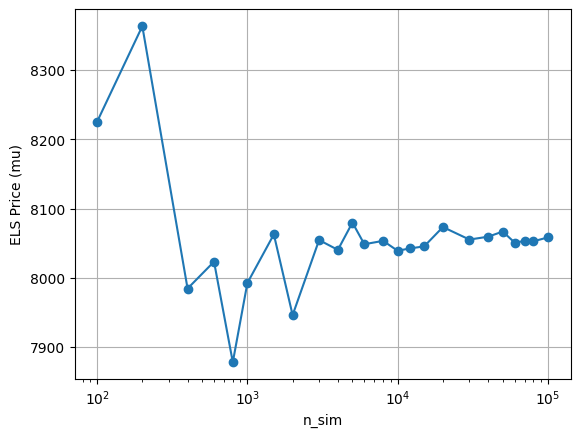

In [14]:
Sims=[100,200,400,600,800,1000,1500,2000,3000,4000,
      5000,6000,8000,10000,12000,15000,20000,30000,
      40000,50000,60000,70000,80000,100000]

Price_Sims=[]
for sim in Sims:
    res=SD_2star_GPU_CRN(S0, kijun, K, T, c, r, q, sigma, rho, barrier, dummy, sim)
    Price_Sims.append(res)

plt.figure()
plt.plot(Sims, Price_Sims, marker='o')
plt.xscale('log')  # 로그스케일로 보면 수렴이 잘 보임
plt.xlabel("n_sim")
plt.ylabel("ELS Price (mu)")
plt.grid(True)
plt.show()

In [16]:
import numpy as np

def MC_Greeks_SD2_GPU_CRN(
    pricer,   # SD_2star_GPU_CRN
    S0, kijun, K, T, c, r, q, sigma, rho, barrier, dummy,
    sim, seed=111, antithetic=True,
    notional=10000.0, dtype="float64",
    bump_S_frac=0.01,       # eps_S[i] = S0[i]*sigma[i]*bump_S_frac
    bump_sigma_frac=0.01,   # eps_sigma[i] = sigma[i]*bump_sigma_frac
    bump_r_bp=1             # r bump: 1bp
):
    """
    2자산(worst-of) StepDown ELS의 CRN Greeks (GPU)

    요구사항(pricer=SD_2star_GPU_CRN):
    - pricer(..., Z=None, return_Z=True) -> (price, Z)
    - pricer(..., Z=Z, return_Z=False) -> price
    - Z shape: (N, sim, 2) (N=T[-1])
    """

    # ---- 입력 정리 ----
    S0 = np.asarray(S0, dtype=float).reshape(2,)
    kijun = np.asarray(kijun, dtype=float).reshape(2,)

    q = np.asarray(q, dtype=float).reshape(2,)
    sigma = np.asarray(sigma, dtype=float).reshape(2,)

    T = np.atleast_1d(np.asarray(T, dtype=int))
    K = np.atleast_1d(np.asarray(K, dtype=float))
    c = np.atleast_1d(np.asarray(c, dtype=float))

    if not (len(T) == len(K) == len(c)):
        raise ValueError("K, T, c 길이는 같아야 합니다.")

    # ---- 0) CRN용 Z 1회 생성 + base price ----
    C0, Z = pricer(
        S0, kijun, K, T, c, r, q, sigma, rho, barrier, dummy,
        sim=sim, seed=seed, antithetic=antithetic,
        Z=None, return_Z=True, notional=notional, dtype=dtype
    )

    # ======================================================
    # 1) Delta / Gamma (각 자산별)
    # ======================================================
    Delta = np.zeros(2, dtype=float)
    Gamma = np.zeros(2, dtype=float)

    for j in range(2):
        eps_Sj = S0[j] * sigma[j] * bump_S_frac
        eps_Sj = max(eps_Sj, 1e-12)

        S_up = S0.copy();   S_up[j] += eps_Sj
        S_dn = S0.copy();   S_dn[j] -= eps_Sj

        Cp = pricer(
            S_up, kijun, K, T, c, r, q, sigma, rho, barrier, dummy,
            sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype
        )
        Cm = pricer(
            S_dn, kijun, K, T, c, r, q, sigma, rho, barrier, dummy,
            sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype
        )

        Delta[j] = (Cp - Cm) / (2.0 * eps_Sj)
        Gamma[j] = (Cp - 2.0 * C0 + Cm) / (eps_Sj ** 2)

    # (선택) Cross-Gamma: d2C/dS1dS2 (혼합 2차 미분)
    eps_S1 = max(S0[0] * sigma[0] * bump_S_frac, 1e-12)
    eps_S2 = max(S0[1] * sigma[1] * bump_S_frac, 1e-12)

    S_pp = S0 + np.array([+eps_S1, +eps_S2])
    S_pm = S0 + np.array([+eps_S1, -eps_S2])
    S_mp = S0 + np.array([-eps_S1, +eps_S2])
    S_mm = S0 + np.array([-eps_S1, -eps_S2])

    C_pp = pricer(S_pp, kijun, K, T, c, r, q, sigma, rho, barrier, dummy,
                  sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype)
    C_pm = pricer(S_pm, kijun, K, T, c, r, q, sigma, rho, barrier, dummy,
                  sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype)
    C_mp = pricer(S_mp, kijun, K, T, c, r, q, sigma, rho, barrier, dummy,
                  sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype)
    C_mm = pricer(S_mm, kijun, K, T, c, r, q, sigma, rho, barrier, dummy,
                  sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype)

    CrossGamma = (C_pp - C_pm - C_mp + C_mm) / (4.0 * eps_S1 * eps_S2)

    # ======================================================
    # 2) Vega (각 자산별, 1% Vega)
    # ======================================================
    Vega = np.zeros(2, dtype=float)
    Vega_1pct = np.zeros(2, dtype=float)

    for j in range(2):
        eps_sigj = sigma[j] * bump_sigma_frac
        eps_sigj = max(eps_sigj, 1e-12)

        sig_up = sigma.copy(); sig_up[j] += eps_sigj
        sig_dn = sigma.copy(); sig_dn[j] -= eps_sigj

        Csig_p = pricer(
            S0, kijun, K, T, c, r, q, sig_up, rho, barrier, dummy,
            sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype
        )
        Csig_m = pricer(
            S0, kijun, K, T, c, r, q, sig_dn, rho, barrier, dummy,
            sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype
        )

        Vega[j] = (Csig_p - Csig_m) / (2.0 * eps_sigj)
        Vega_1pct[j] = 0.01 * Vega[j]

    # ======================================================
    # 3) Theta (1-day): 모든 관측일 1일 당김
    # ======================================================
    Tm = np.maximum(T - 1, 0)

    Ct = pricer(
        S0, kijun, K, Tm, c, r, q, sigma, rho, barrier, dummy,
        sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype
    )
    Theta_1d = Ct - C0

    # ======================================================
    # 4) Rho (1bp)
    # ======================================================
    eps_r = bump_r_bp * 0.0001

    Cr_p = pricer(
        S0, kijun, K, T, c, r + eps_r, q, sigma, rho, barrier, dummy,
        sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype
    )
    Cr_m = pricer(
        S0, kijun, K, T, c, r - eps_r, q, sigma, rho, barrier, dummy,
        sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype
    )

    Rho_per_unit = (Cr_p - Cr_m) / (2.0 * eps_r)
    Rho_1bp = 0.0001 * Rho_per_unit

    return {
        "Price": C0,
        "Delta": Delta,              # shape (2,)
        "Gamma": Gamma,              # shape (2,)
        "CrossGamma": CrossGamma,    # scalar
        "Vega(1%)": Vega_1pct,       # shape (2,)
        "Theta(1d)": Theta_1d,
        "Rho(1bp)": Rho_1bp,
        "bump": {
            "eps_S": [eps_S1, eps_S2],
            "eps_sigma": list(np.maximum(sigma * bump_sigma_frac, 1e-12)),
            "eps_r": eps_r,
            "CRN": True,
            "antithetic": antithetic,
            "seed": seed,
        }
    }


In [17]:
MC_Greeks_SD2_GPU_CRN(
    pricer=SD_2star_GPU_CRN,
    S0=[100, 100],
    kijun=[100, 95],
    K=K, T=T, c=c,
    r=r, q=[0, 0],
    sigma=[0.3, 0.3],
    rho=0.6,
    barrier=0.65, dummy=0.132,
    sim=20000, seed=111, antithetic=True
)

{'Price': 8765.346106985417,
 'Delta': array([40.55928187, 27.24010251]),
 'Gamma': array([-15.39283137, -26.28862682]),
 'CrossGamma': np.float64(1.4287084418810991),
 'Vega(1%)': array([-34.96675782, -32.42356397]),
 'Theta(1d)': 1.818336637563334,
 'Rho(1bp)': -0.45285424915073236,
 'bump': {'eps_S': [np.float64(0.3), np.float64(0.3)],
  'eps_sigma': [np.float64(0.003), np.float64(0.003)],
  'eps_r': 0.0001,
  'CRN': True,
  'antithetic': True,
  'seed': 111}}